<a href="https://colab.research.google.com/github/Nannanpeng/Heterogeneous_agent_model/blob/master/Hugget_Economy_1993_JEDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade QuantEcon
!pip install interpolation

Requirement already up-to-date: QuantEcon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import quantecon as qe
from quantecon.optimize import brent_max
from numba import njit, jitclass, float64, int32, prange, jit
import matplotlib.pyplot as plt
import numpy as np
from interpolation import interp

## Method 1: Coding from scratch with numba (VFI)

In [3]:
Hugget_data=[('E', float64[:]),
      ('E_mm', float64[:,:]),
      ('a_vals', float64[:]),
      ('beta', float64),
      ('sigma', float64),
      ('n_states', int32),
      ('a_min', float64)]

@jitclass(Hugget_data)
class HuggetEconomy:
  def __init__(self,
         beta=0.99322,
         sigma=1.5,
         E=(0.1, 1.0), 
         E_mm=((0.5, 0.5), 
            (0.075, 0.925)), 
         a_min=-2, 
         a_max=5, 
         n_grids=250):
    self.beta, self.sigma = beta, sigma
    self.a_min = a_min
    self.E, self.E_mm = np.array(E), np.array(E_mm) 
    self.a_vals = np.linspace(a_min, a_max, n_grids)
    self.n_states = int(n_grids * len(E))
  
  def u(self, c):
    return c**(1-self.sigma)/(1-self.sigma) if c >=0 else -10000

@njit
def state_action_value(x, a_next_idx, q, v, hm):
  a_idx, e_idx = x
  a_vals, beta, u, E_mm, E = hm.a_vals, hm.beta, hm.u, hm.E_mm, hm.E
  c = a_vals[a_idx] + E[e_idx] - a_vals[a_next_idx]*q
  value = u(c)
  for e_idx_next in range(len(E_mm)):
    value += beta*v[a_next_idx, e_idx_next]*E_mm[e_idx, e_idx_next]
  return value
  
@njit
def best_action_value(x, q, v, hm):
  action_res = np.empty_like(hm.a_vals)
  for i in range(len(hm.a_vals)):
    action_res[i] = state_action_value(x, i, q, v, hm)
  idx = action_res.argmax()
  return idx, hm.a_vals[idx], action_res[idx]

@njit(parallel=True)
def T(q, v, hm):
  update_v = np.empty_like(v)
  for i in prange(len(hm.a_vals)):
    for j in prange(len(hm.E)):
      x = (i, j)
      _, _, new_v = best_action_value(x, q, v, hm)
      update_v[i, j] = new_v
  return update_v

#@njit
def compute_value_function(q, hm, tol=1e-3, iter_max=10000, verbose=True):
  v = np.vstack((hm.a_vals, hm.a_vals)).T
  err = tol + 1
  i = 0
  while err>tol and i<iter_max:
    Tv = T(q, v, hm)
    err = np.max(np.abs(Tv-v))
    v = Tv
    i += 1
    if i%100==0 and verbose==True:
      print(f"Error = {err}")
  if i == iter_max:
    print('Convergence failed.')
  return v

@njit 
def compute_transition_matrix(q, v, hm):
  n_states, a_vals, E, E_mm = hm.n_states, hm.a_vals, hm.E, hm.E_mm
  P = np.zeros((n_states, n_states))
  e_size = len(E)
  for i in range(n_states):
    a_idx = i//e_size
    e_idx = i%e_size
    x = (a_idx, e_idx)
    new_a_idx, _, _ = best_action_value(x, q, v, hm)
    for new_e_idx in range(len(E_mm)):
      i_new = new_a_idx*e_size + new_e_idx
      P[i, i_new] = E_mm[e_idx, new_e_idx]
  return P

@njit
def compute_stationary_distribution(P, tol=1e-10, iter_max=1000000):
  n = len(P)
  psi = np.full(n, 1/n)
  err = 1+tol
  i = 0
  while err>tol and i < iter_max:
    new_psi = psi @ P
    err = np.max(np.abs(new_psi - psi))
    psi = new_psi
    i += 1
  if i == iter_max:
    print('Iteration failed.')
  return psi

@njit
def check_market_clear_condition(psi, q, v, hm):
  #psi = compute_stationary_distribution(P)
  savings = np.empty_like(psi)
  e_size = len(hm.E)
  for i in range(hm.n_states):
    a_idx = i//e_size
    e_idx = i%e_size
    x = (a_idx, e_idx)
    _, saving, _ = best_action_value(x, q, v, hm)
    savings[i] = saving
  total_savings = np.sum(savings * psi)
  return total_savings

#@njit
def search_price(hm, q_high=1.5, tol=1e-2):
  a_min, e_low, beta = hm.a_min, hm.E[0], hm.beta
  q_low = max((a_min+e_low)/a_min, beta)
  err = tol+1
  while err>tol:
    q = (q_low + q_high)/2
    v = compute_value_function(q, hm, verbose=False)
    P = compute_transition_matrix(q, v, hm)
    psi = qe.MarkovChain(P).stationary_distributions[0]
    total_savings = check_market_clear_condition(psi, q, v, hm)
    err = np.abs(total_savings)
    if total_savings > 0:
      q_low = q
    else: 
      q_high = q
  return q

def interest_rate(q):
  return 1/q**6 - 1

CPU times: user 24.8 s, sys: 1.06 s, total: 25.8 s
Wall time: 14.3 s


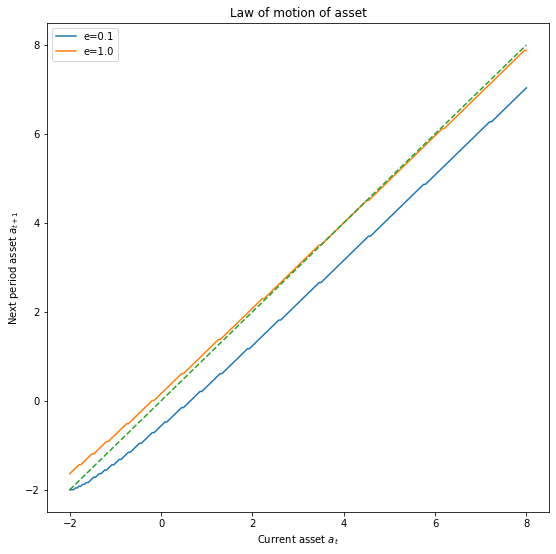

In [4]:
%%time
q = 1
hm = HuggetEconomy(a_min=-2, a_max=8, n_grids=250)
v = compute_value_function(q, hm, verbose=False)
next_asset = np.empty_like(v)
for i in range(len(hm.a_vals)):
  for j in range(len(hm.E)):
    _, action, _ = best_action_value((i, j), q, v, hm)
    next_asset[i, j] = action

fig, ax = plt.subplots(figsize=(9, 9))
for i in range(len(hm.E)):
  ax.plot(hm.a_vals, next_asset[:, i], label=f'e={hm.E[i]}')
ax.plot(hm.a_vals, hm.a_vals, '--')
ax.set(xlabel=r'Current asset $a_t$', ylabel=r'Next period asset $a_{t+1}$', title='Law of motion of asset')
ax.legend();

CPU times: user 1.66 s, sys: 37.1 ms, total: 1.7 s
Wall time: 1.65 s


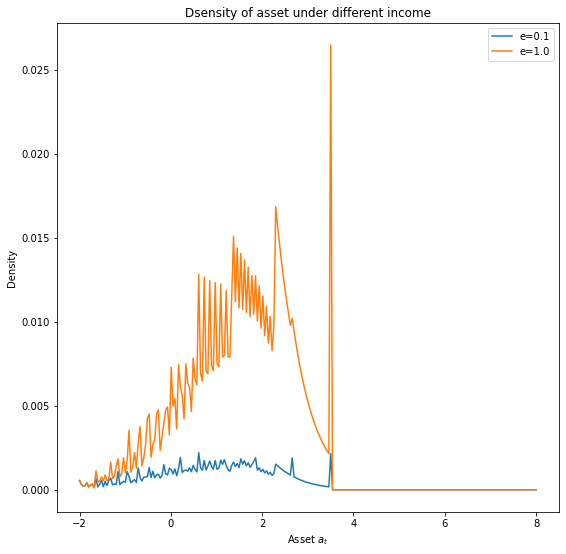

In [5]:
%%time
P = compute_transition_matrix(q, v, hm)
s_probs = compute_stationary_distribution(P)
asset_probs = np.empty((len(hm.a_vals), len(hm.E)))
for i in range(hm.n_states):
  a_idx = i//len(hm.E)
  e_idx = i%len(hm.E)
  asset_probs[a_idx, e_idx] = s_probs[i]

fig, ax = plt.subplots(figsize=(9, 9))
for i in range(len(hm.E)):
  ax.plot(hm.a_vals, asset_probs[:, i], label=f'e={hm.E[i]}')
ax.set(xlabel=r'Asset $a_t$', ylabel='Density', title='Dsensity of asset under different income')
ax.legend();

In [6]:
%%time
for a_min in [-2, -4, -6, -8]:
  hm = HuggetEconomy(a_min=a_min, n_grids=250)
  q = search_price(hm)
  r = interest_rate(q)
  print(f'a_min = {a_min:.01f}, r = {r*100:.02f}%, q = {q:.05f}')

a_min = -2.0, r = -7.33%, q = 1.01277
a_min = -4.0, r = 1.20%, q = 0.99801
a_min = -6.0, r = 3.04%, q = 0.99501
a_min = -8.0, r = 3.69%, q = 0.99398
CPU times: user 19min 59s, sys: 56.6 s, total: 20min 55s
Wall time: 10min 41s


In [7]:
%%time
for a_min in [-2, -4, -6, -8]:
  hm = HuggetEconomy(a_min=a_min, n_grids=250, sigma=3)
  q = search_price(hm)
  r = interest_rate(q)
  print(f'a_min = {a_min:.01f}, r = {r*100:.02f}%, q = {q:.05f}')

a_min = -2.0, r = -23.73%, q = 1.04617
a_min = -4.0, r = -4.35%, q = 1.00745
a_min = -6.0, r = 0.79%, q = 0.99869
a_min = -8.0, r = 2.58%, q = 0.99577
CPU times: user 17min 24s, sys: 48.7 s, total: 18min 13s
Wall time: 9min 22s


## Method 2: Using QuantEcon library discrete DP (PFI)

In [8]:
class HuggetEconomy2:
  def __init__(self,
         beta=0.99322,
         sigma=1.5,
         q = 1,
         E=[0.1, 1.0], 
         E_mm=((0.5, 0.5), 
            (0.075, 0.925)), 
         a_min=-2, 
         a_max=5, 
         n_grids=250):
    self.beta, self.sigma = beta, sigma
    self.a_min = a_min
    self.q, self.m = q, n_grids
    self.E, self.E_mm = np.array(E), np.array(E_mm) 
    self.a_vals = np.linspace(a_min, a_max, n_grids)
    self.n_states = int(n_grids * len(E))
    self.R = np.empty((self.n_states, self.m))
    self.build_R()
    self.Q = np.zeros((self.n_states, self.m, self.n_states))
    self.build_Q()
  
  def u(self, c):
    return c**(1-self.sigma)/(1-self.sigma) if c >=0 else -10000

  def set_price(self, q):
    self.q = q
    self.build_R()

  def build_R(self):
    populate_R(self.n_states, self.m, self.q, \
          self.a_vals, self.E, self.sigma, self.R)

  def build_Q(self):
    populate_Q(self.n_states, 
          self.m,
          self.E_mm,
          self.Q)

@jit(nopython=True)
def populate_R(n, m, q, a_vals, e_vals, sigma, R):
  e_size = len(e_vals)
  for i in range(n):
    a_idx = i//e_size
    e_idx = i%e_size
    for j in range(m):
      c = a_vals[a_idx] + e_vals[e_idx] - a_vals[j] * q
      R[i, j] = c**(1-sigma)/(1-sigma) if c >=0 else -10000

@njit
def populate_Q(n, m, mc, Q):
  e_size = len(mc)
  for i in range(n):
    a_idx = i//e_size
    e_idx = i%e_size
    for j in range(m):
      for e_idx_next in range(e_size):
        i_next = j*e_size + e_idx_next
        Q[i, j, i_next] = mc[e_idx, e_idx_next]

@njit
def asset_marginal(s_probs, a_size, e_size):
  a_probs = np.zeros(a_size)
  for i in range(a_size):
    for j in range(e_size):
      a_probs[i] += s_probs[i*e_size + j]
  return a_probs

def search_price2(hm, q_high=1.5, tol=1e-2):
  a_min, e_low, beta = hm.a_min, hm.E[0], hm.beta
  q_low = max((a_min+e_low)/a_min, beta)
  err = tol+1
  while err>tol:
    q = (q_low + q_high)/2
    hm.set_price(q)
    hm_ddp = qe.markov.DiscreteDP(hm.R, hm.Q, beta=hm.beta)
    results = hm_ddp.solve(method='policy_iteration')
    s_probs = results.mc.stationary_distributions[0]
    a_probs = asset_marginal(s_probs, len(hm.a_vals), len(hm.E))
    total_savings = np.sum(a_probs*hm.a_vals)
    err = np.abs(total_savings)
    if total_savings > 0:
      q_low = q
    else: 
      q_high = q
  return q

CPU times: user 2.93 s, sys: 2.18 s, total: 5.11 s
Wall time: 3.41 s


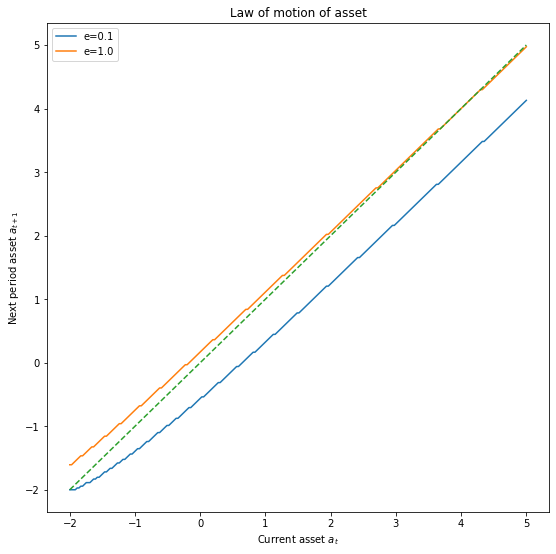

In [9]:
%%time
hm2 = HuggetEconomy2()
hm_ddp = qe.markov.DiscreteDP(hm2.R, hm2.Q, beta=hm2.beta)
results = hm_ddp.solve(method='policy_iteration')
next_asset = np.empty((len(hm2.a_vals), len(hm2.E)))
for i in range(hm2.n_states):
  a_idx = i//len(hm2.E)
  e_idx = i%len(hm2.E)
  next_asset[a_idx, e_idx] = hm2.a_vals[results.sigma[i]]

fig, ax = plt.subplots(figsize=(9, 9))
for i in range(len(hm2.E)):
  ax.plot(hm2.a_vals, next_asset[:, i], label=f'e={hm2.E[i]}')
ax.plot(hm2.a_vals, hm2.a_vals, '--')
ax.set(xlabel=r'Current asset $a_t$', ylabel=r'Next period asset $a_{t+1}$', title='Law of motion of asset')
ax.legend();

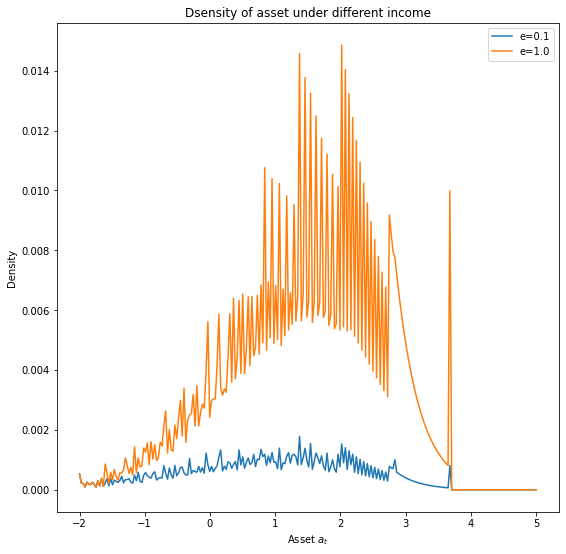

In [10]:
s_probs = results.mc.stationary_distributions[0]
asset_probs = np.empty((len(hm2.a_vals), len(hm2.E)))
for i in range(hm2.n_states):
  a_idx = i//len(hm2.E)
  e_idx = i%len(hm2.E)
  asset_probs[a_idx, e_idx] = s_probs[i]

fig, ax = plt.subplots(figsize=(9, 9))
for i in range(len(hm2.E)):
  ax.plot(hm2.a_vals, asset_probs[:, i], label=f'e={hm2.E[i]}')
ax.set(xlabel=r'Asset $a_t$', ylabel='Density', title='Dsensity of asset under different income')
ax.legend();

In [11]:
%%time
for a_min in [-2, -4, -6, -8]:
  hm2 = HuggetEconomy2(a_min=a_min)
  q = search_price2(hm2)
  r = interest_rate(q)
  print(f'a_min = {a_min:.01f}, r = {r*100:.02f}%, q = {q:.05f}')

a_min = -2.0, r = -7.33%, q = 1.01277
a_min = -4.0, r = 1.20%, q = 0.99801
a_min = -6.0, r = 3.04%, q = 0.99501
a_min = -8.0, r = 3.69%, q = 0.99398
CPU times: user 1min 33s, sys: 1min 7s, total: 2min 41s
Wall time: 1min 25s


In [12]:
%%time

for a_min in [-2, -4, -6, -8]:
  hm2 = HuggetEconomy2(a_min=a_min, n_grids=250, sigma=3)
  q = search_price2(hm2)
  r = interest_rate(q)
  print(f'a_min = {a_min:.01f}, r = {r*100:.02f}%, q = {q:.05f}')

a_min = -2.0, r = -23.73%, q = 1.04617
a_min = -4.0, r = -4.35%, q = 1.00745
a_min = -6.0, r = 0.79%, q = 0.99869
a_min = -8.0, r = 2.58%, q = 0.99577
CPU times: user 1min 41s, sys: 1min 7s, total: 2min 48s
Wall time: 1min 28s
